# Testing the Right Arm

**Warning:** Before running this notebook, first make sure you understand the command you run and make sure that the robot can freely move.

**Note:** Also stop all other running Python script or notebook connected to the robot as only one connection can run at the same time.

In [1]:
#%matplotlib notebook

import time
import numpy as np

#from matplotlib import pyplot as plt

In [2]:
from collections import OrderedDict
from reachy import parts

def patch_force_gripper(forceGripper):
    def __init__(self, root, io):
        """Create a new Force Gripper Hand."""
        parts.hand.Hand.__init__(self, root=root, io=io)

        dxl_motors = OrderedDict({
            name: dict(conf)
            for name, conf in self.dxl_motors.items()
        })

        self.attach_dxl_motors(dxl_motors)

        """
        self._load_sensor = self.io.find_module('force_gripper')
        self._load_sensor.offset = 4
        self._load_sensor.scale = 10000
        """

    forceGripper.__init__ = __init__

    return forceGripper


## Connect to the right arm

In [3]:
from reachy import Reachy, parts

In [5]:
# parts.RightArm = patch_right_arm_config(parts.RightArm)        

In [6]:
parts.arm.RightForceGripper = patch_force_gripper(parts.arm.RightForceGripper)

In [11]:
reachy = Reachy(
      right_arm=parts.RightArm(io='/dev/ttyUSB*', hand='force_gripper'),
#     right_arm=parts.RightArm(io='ws', hand='force_gripper'),
)

ValueError: No corresponding IO found (among <function discover_hosts at 0x7f6249e29d30>).

You can now connect your robot in Unity.

## Check motors

Check that all motors are presents

In [7]:
for m in reachy.right_arm.motors:
    print(f'{m.name} - pos:{m.present_position} temp:{m.temperature}')

right_arm.shoulder_pitch - pos:0.0 temp:20
right_arm.shoulder_roll - pos:0.0 temp:20
right_arm.arm_yaw - pos:-0.0 temp:20
right_arm.elbow_pitch - pos:-0.0 temp:20
right_arm.hand.forearm_yaw - pos:-0.0 temp:20
right_arm.hand.wrist_pitch - pos:-0.0 temp:20
right_arm.hand.wrist_roll - pos:-0.0 temp:20
right_arm.hand.gripper - pos:0.0 temp:20


Move the arm and check that the position are moving

Check that all motors are turning compliant/stiff.

## Turn stiff/compliant

In [8]:
for m in reachy.right_arm.motors:
    m.compliant = False

In [9]:
for m in reachy.right_arm.motors:
    m.compliant = True

## Goto 0 pos + 90 on the elbow

In [10]:
for m in reachy.right_arm.motors:
    m.compliant = False

In [15]:
reachy.goto({
    'right_arm.shoulder_pitch': -30,
    'right_arm.shoulder_roll': -50,
    'right_arm.arm_yaw': 0,    
    'right_arm.elbow_pitch': -90,
    'right_arm.hand.forearm_yaw': -40,
    'right_arm.hand.wrist_pitch': 0,
    'right_arm.hand.wrist_roll': 0,
    'right_arm.hand.gripper': 0,
}, duration=3, wait=True)

Check that everything seems fine.

In [37]:
reachy.right_arm.motors

[<DxlMotor "right_arm.shoulder_pitch" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.shoulder_roll" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.arm_yaw" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.elbow_pitch" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.hand.forearm_yaw" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.hand.wrist_pitch" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.hand.wrist_roll" pos="0.0" mode="stiff">,
 <DxlMotor "right_arm.hand.gripper" pos="0.0" mode="stiff">]

In [38]:
for m in reachy.right_arm.motors:
    m.compliant = True

## Record a trajectory and replay it

*This part doesn't really seem to work with the simulator. - PC*

In [39]:
from reachy.trajectory import TrajectoryRecorder, TrajectoryPlayer

In [40]:
recorder = TrajectoryRecorder(reachy.right_arm.motors)

We will record a move for 10sec. Make sure you hold the robot away from all objects before starting the record.

In [41]:
recorder.start()
time.sleep(20)
recorder.stop()

Turn all motors stiff (try putting the robot in about its starting position of the trajectory).

In [42]:
for m in reachy.right_arm.motors:
    m.compliant = False

In [43]:
player = TrajectoryPlayer(reachy, recorder.trajectories)
player.play(wait=True, fade_in_duration=.5)

Turn it back compliant.

In [44]:
for m in reachy.right_arm.motors:
    m.compliant = True

Look at the recorded traj.

<IPython.core.display.Javascript object>


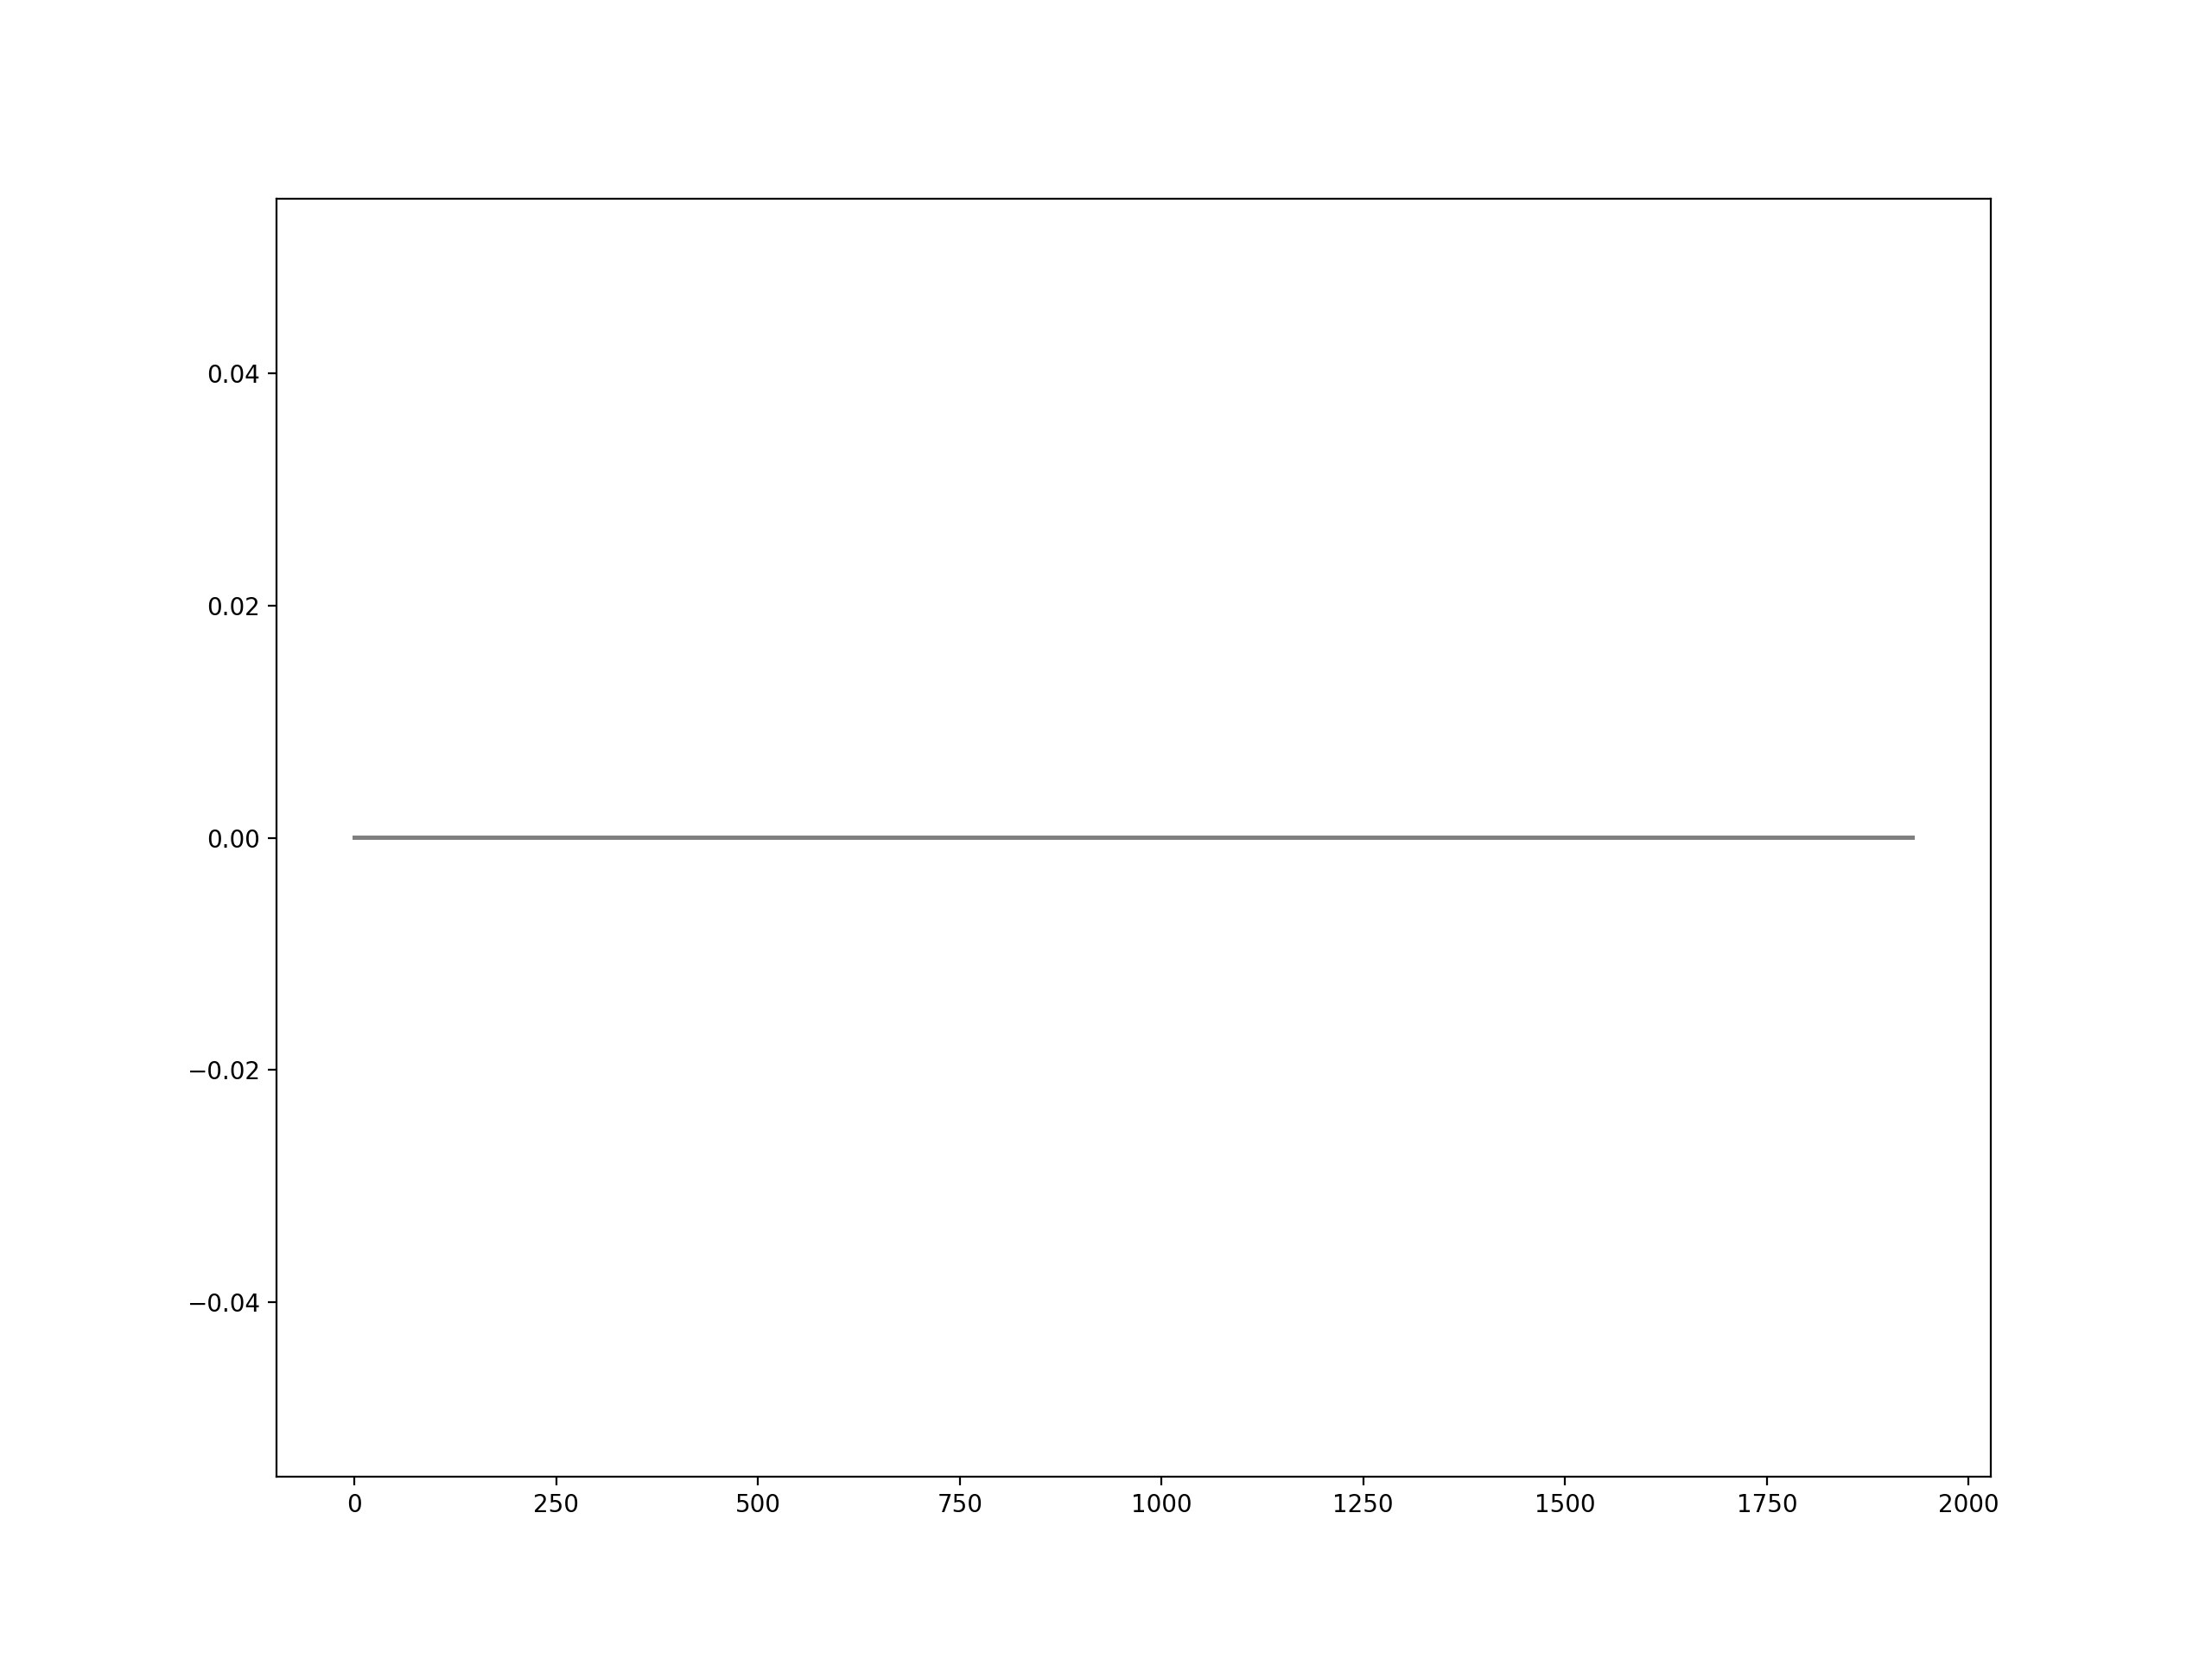

In [45]:
plt.figure()

for k, v in recorder.trajectories.items():
    plt.plot(v, label=k)
# plt.legend()

## Grasp objects

Put an object inside the hand of the robot and then run the line below to close it.

In [ ]:
reachy.right_arm.hand.gripper.compliant = False

In [ ]:
reachy.right_arm.hand.close()

Check that the close method returned true. Check the object holds in its hand while moving the arm manually.

*This returns false because you can't really put in anything in Reachy's hand in the simulator. - PC*

Then we reopen the hand.

In [ ]:
reachy.right_arm.hand.open()

In [ ]:
reachy.right_arm.hand.gripper.compliant = True

## Check kinematics

Put the arm in a position where its hand is facing forward and where it can move at least 10cm in all direction.

In [ ]:
for m in reachy.right_arm.motors:
    m.compliant = False

In [ ]:
J0 = [m.present_position for m in reachy.right_arm.motors]

M = reachy.right_arm.forward_kinematics(J0)

M1 = M.copy()
M1[0, 3] += 0.05
J1 = reachy.right_arm.inverse_kinematics(M1, J0)

M2 = M.copy()
M2[0, 3] -= 0.05
J2 = reachy.right_arm.inverse_kinematics(M2, J0)

M3 = M.copy()
M3[1, 3] += 0.05
J3 = reachy.right_arm.inverse_kinematics(M3, J0)

M4 = M.copy()
M4[1, 3] -= 0.05
J4 = reachy.right_arm.inverse_kinematics(M4, J0)

In [ ]:
_ = reachy.goto({m.name: j for j, m in zip(J1, reachy.right_arm.motors)}, duration=1, wait=True)
_ = reachy.goto({m.name: j for j, m in zip(J2, reachy.right_arm.motors)}, duration=1, wait=True)
_ = reachy.goto({m.name: j for j, m in zip(J3, reachy.right_arm.motors)}, duration=1, wait=True)
_ = reachy.goto({m.name: j for j, m in zip(J4, reachy.right_arm.motors)}, duration=1, wait=True)
_ = reachy.goto({m.name: j for j, m in zip(J0, reachy.right_arm.motors)}, duration=1, wait=True)

In [ ]:
for m in reachy.right_arm.motors:
    m.compliant = True

## Check the fans

*I'm not really sure if this does anything in the simulator. - PC*

In [ ]:
reachy.right_arm.shoulder_fan.on()

In [ ]:
reachy.right_arm.shoulder_fan.off()

In [ ]:
reachy.right_arm.elbow_fan.on()

In [ ]:
reachy.right_arm.elbow_fan.off()

In [ ]:
reachy.right_arm.wrist_fan.on()

In [ ]:
reachy.right_arm.wrist_fan.off()